<a href="https://colab.research.google.com/github/aashleychen/DNSC3288_Project/blob/main/DNSC3288_Project_G6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Prices - LGBM

MIT License

Copyright (c) 2024 aashleychen

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

Importing Packages

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore') # set enviroment to ignore all warnings
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) # display floating- point numbers in a more readable format with 3 decimal places

In [38]:
# Print the versions of the packages
print("matplotlib:", plt.matplotlib.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("seaborn:", sns.__version__)
print("scikit-learn:", sklearn.__version__)
print("lightgbm:", lgb.__version__)

matplotlib: 3.8.0
numpy: 1.26.4
pandas: 2.2.2
seaborn: 0.13.2
scikit-learn: 1.5.2
lightgbm: 4.5.0


In [39]:
# print version of Python
import platform
print("Python version:", platform.python_version())

Python version: 3.10.12


### Loading and Preparing the Data

In [40]:
# Read the CSV
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

# Keep original data clean
train_data = train_set.copy()
test_data = test_set.copy()
train_ids = train_data['Id'].copy()
test_ids = test_data['Id'].copy()

In [41]:
# shape of train and test data sets
print('Train data original shape: {}'.format(train_data.shape))
print('Test data original shape: {}'.format(test_data.shape))

Train data original shape: (1460, 81)
Test data original shape: (1459, 80)


In [42]:
#look at first 5 rows of the train data
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [43]:
#dropping the Id column for both the train and test data sets
train_data = train_data.drop('Id',axis=1)
test_data = test_data.drop('Id',axis=1)

## Explore the Data

### Sale Price

In [44]:
train_data['SalePrice'].describe()
# get a statistical summary of the SalePrice column

,SalePrice
count,1460.000
mean,180921.196
std,79442.503
min,34900.000
25%,129975.000
50%,163000.000
75%,214000.000
max,755000.000


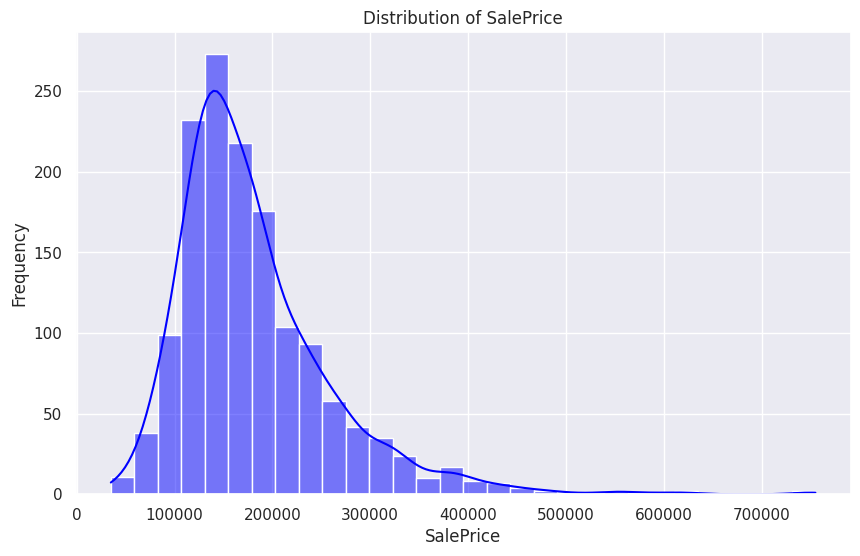

In [45]:
# Visualizing the target variable `SalePrice` distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], kde=True, bins=30, color='blue')
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

* Positive (right) skewed distribution : some houses with higher price tag is making the mean greater than the median

* Peakedness : sharper peak, longer tails means more values are clustered around the mean and there are more extreme outliers

#### Sale Price and Overall Quality

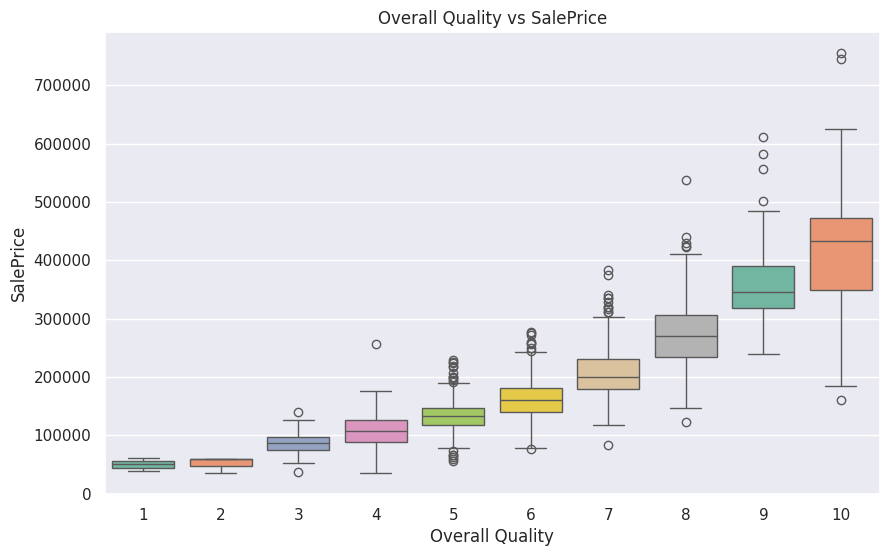

In [46]:
# Visualizing the distribution of key features
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_data, x='OverallQual', y='SalePrice', palette='Set2')
plt.title("Overall Quality vs SalePrice")
plt.xlabel("Overall Quality")
plt.ylabel("SalePrice")
plt.show()

#### Sale Price and Year Built

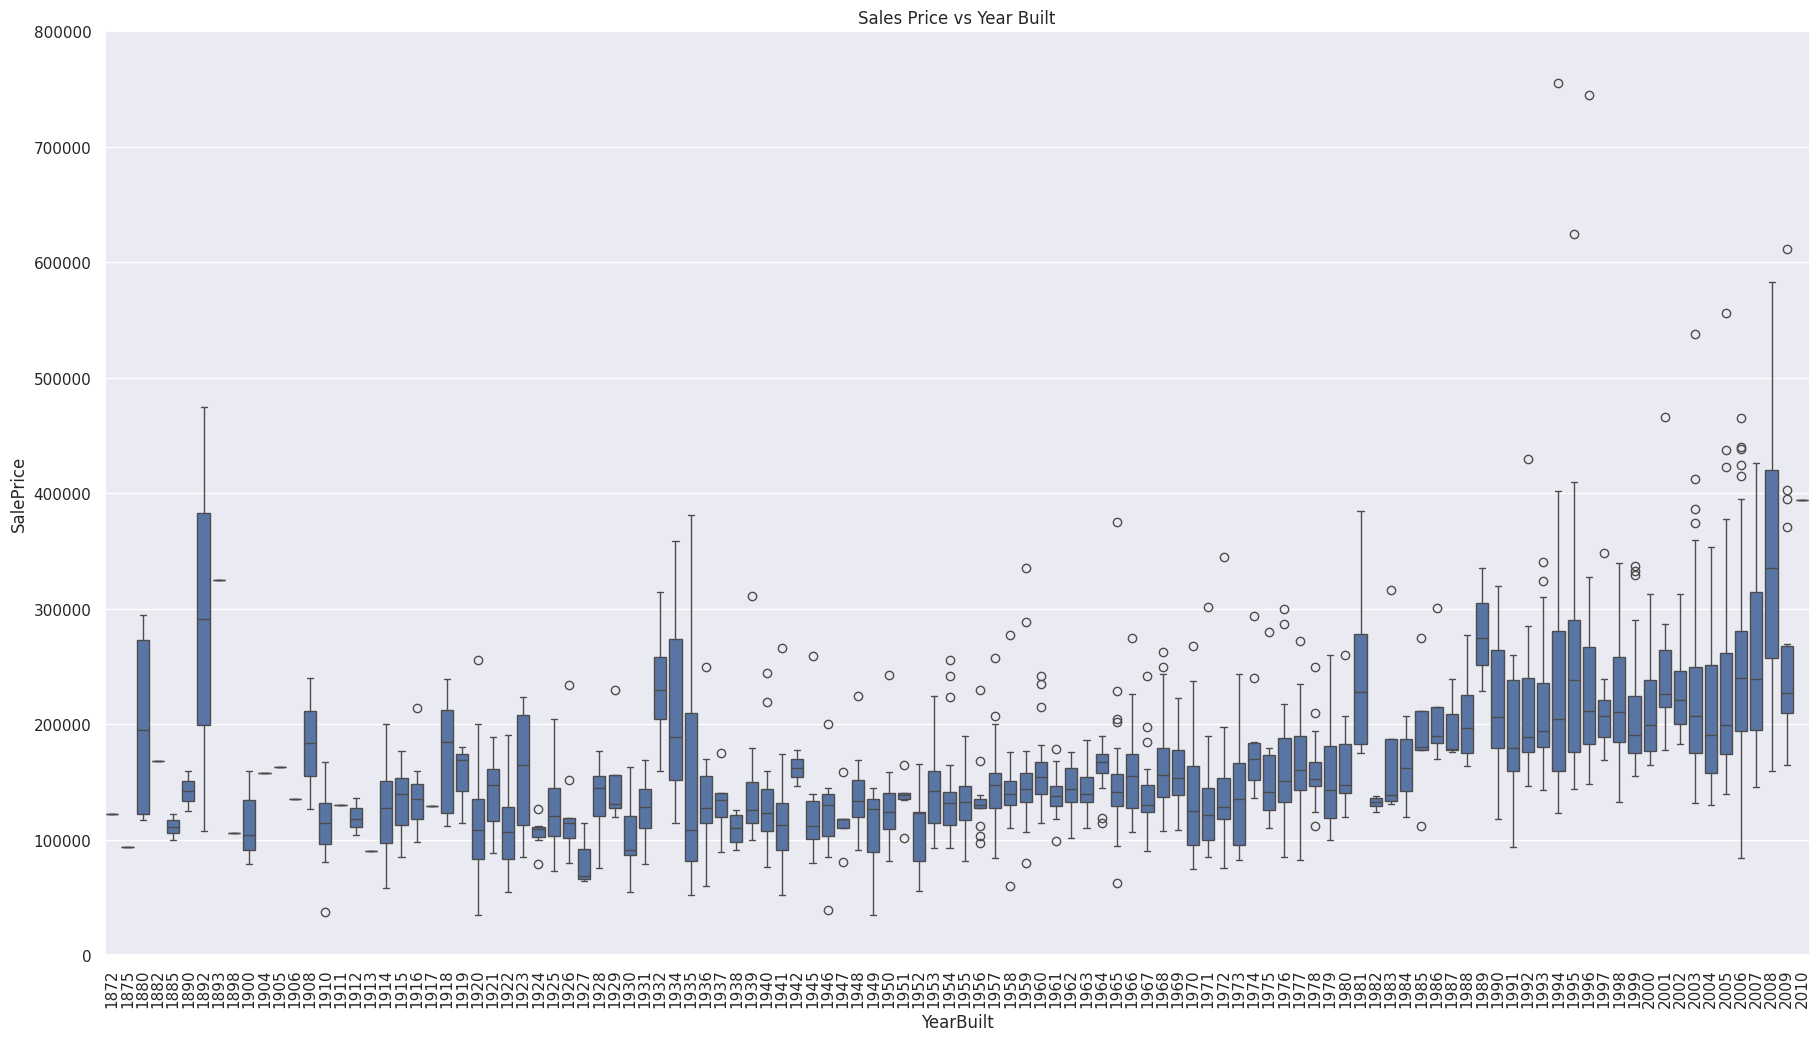

In [47]:
var = 'YearBuilt'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(22, 12))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.title("Sales Price vs Year Built")
plt.xticks(rotation=90);

Conclusions:
* 'GrLivArea' and 'TotalBsmtSF' linearly related with 'SalePrice'
* Both relationships are positive
* 'OverallQual' and 'YearBuilt' also related to 'SalePrice'

### Correlations

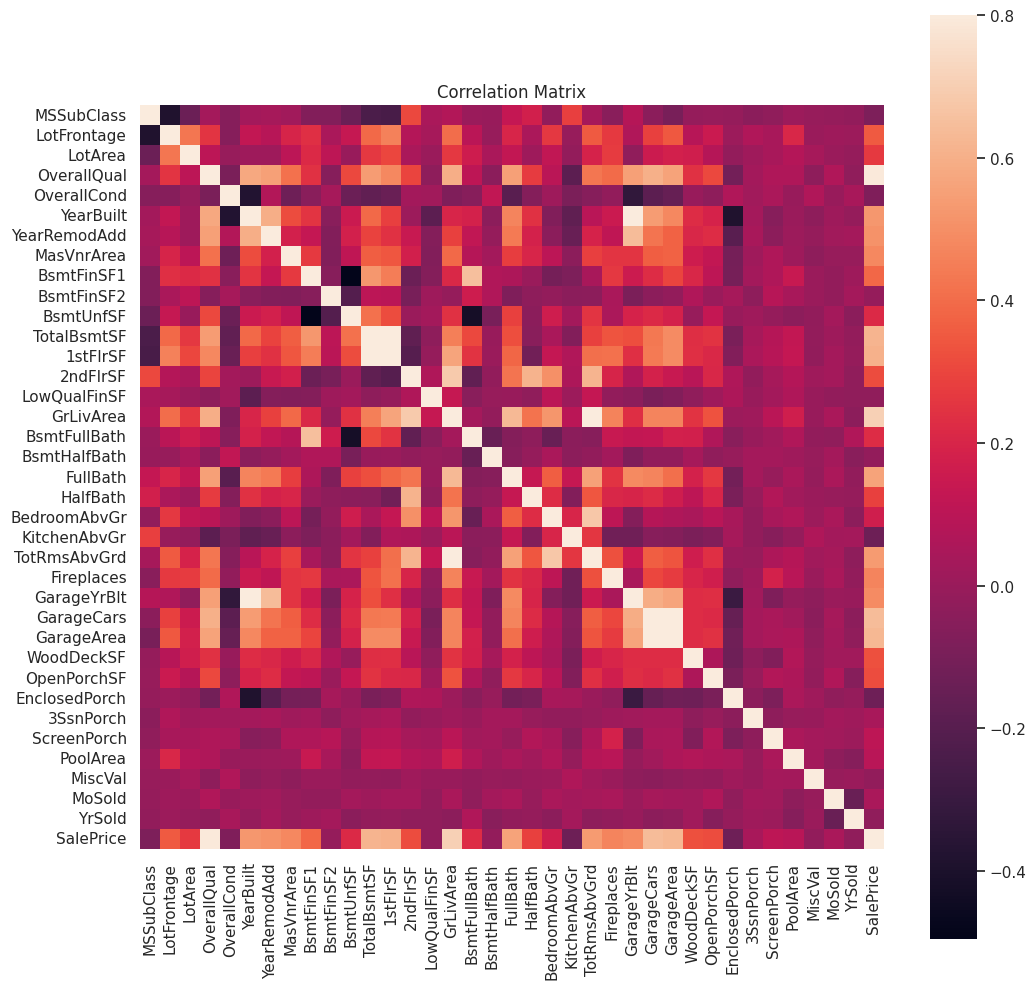

In [48]:
corrs_matrix = train_data.select_dtypes(include=['number']).corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrs_matrix, vmax=.8, square=True)
plt.title('Correlation Matrix')
plt.show()

### Scatterplot with Correlated Variables

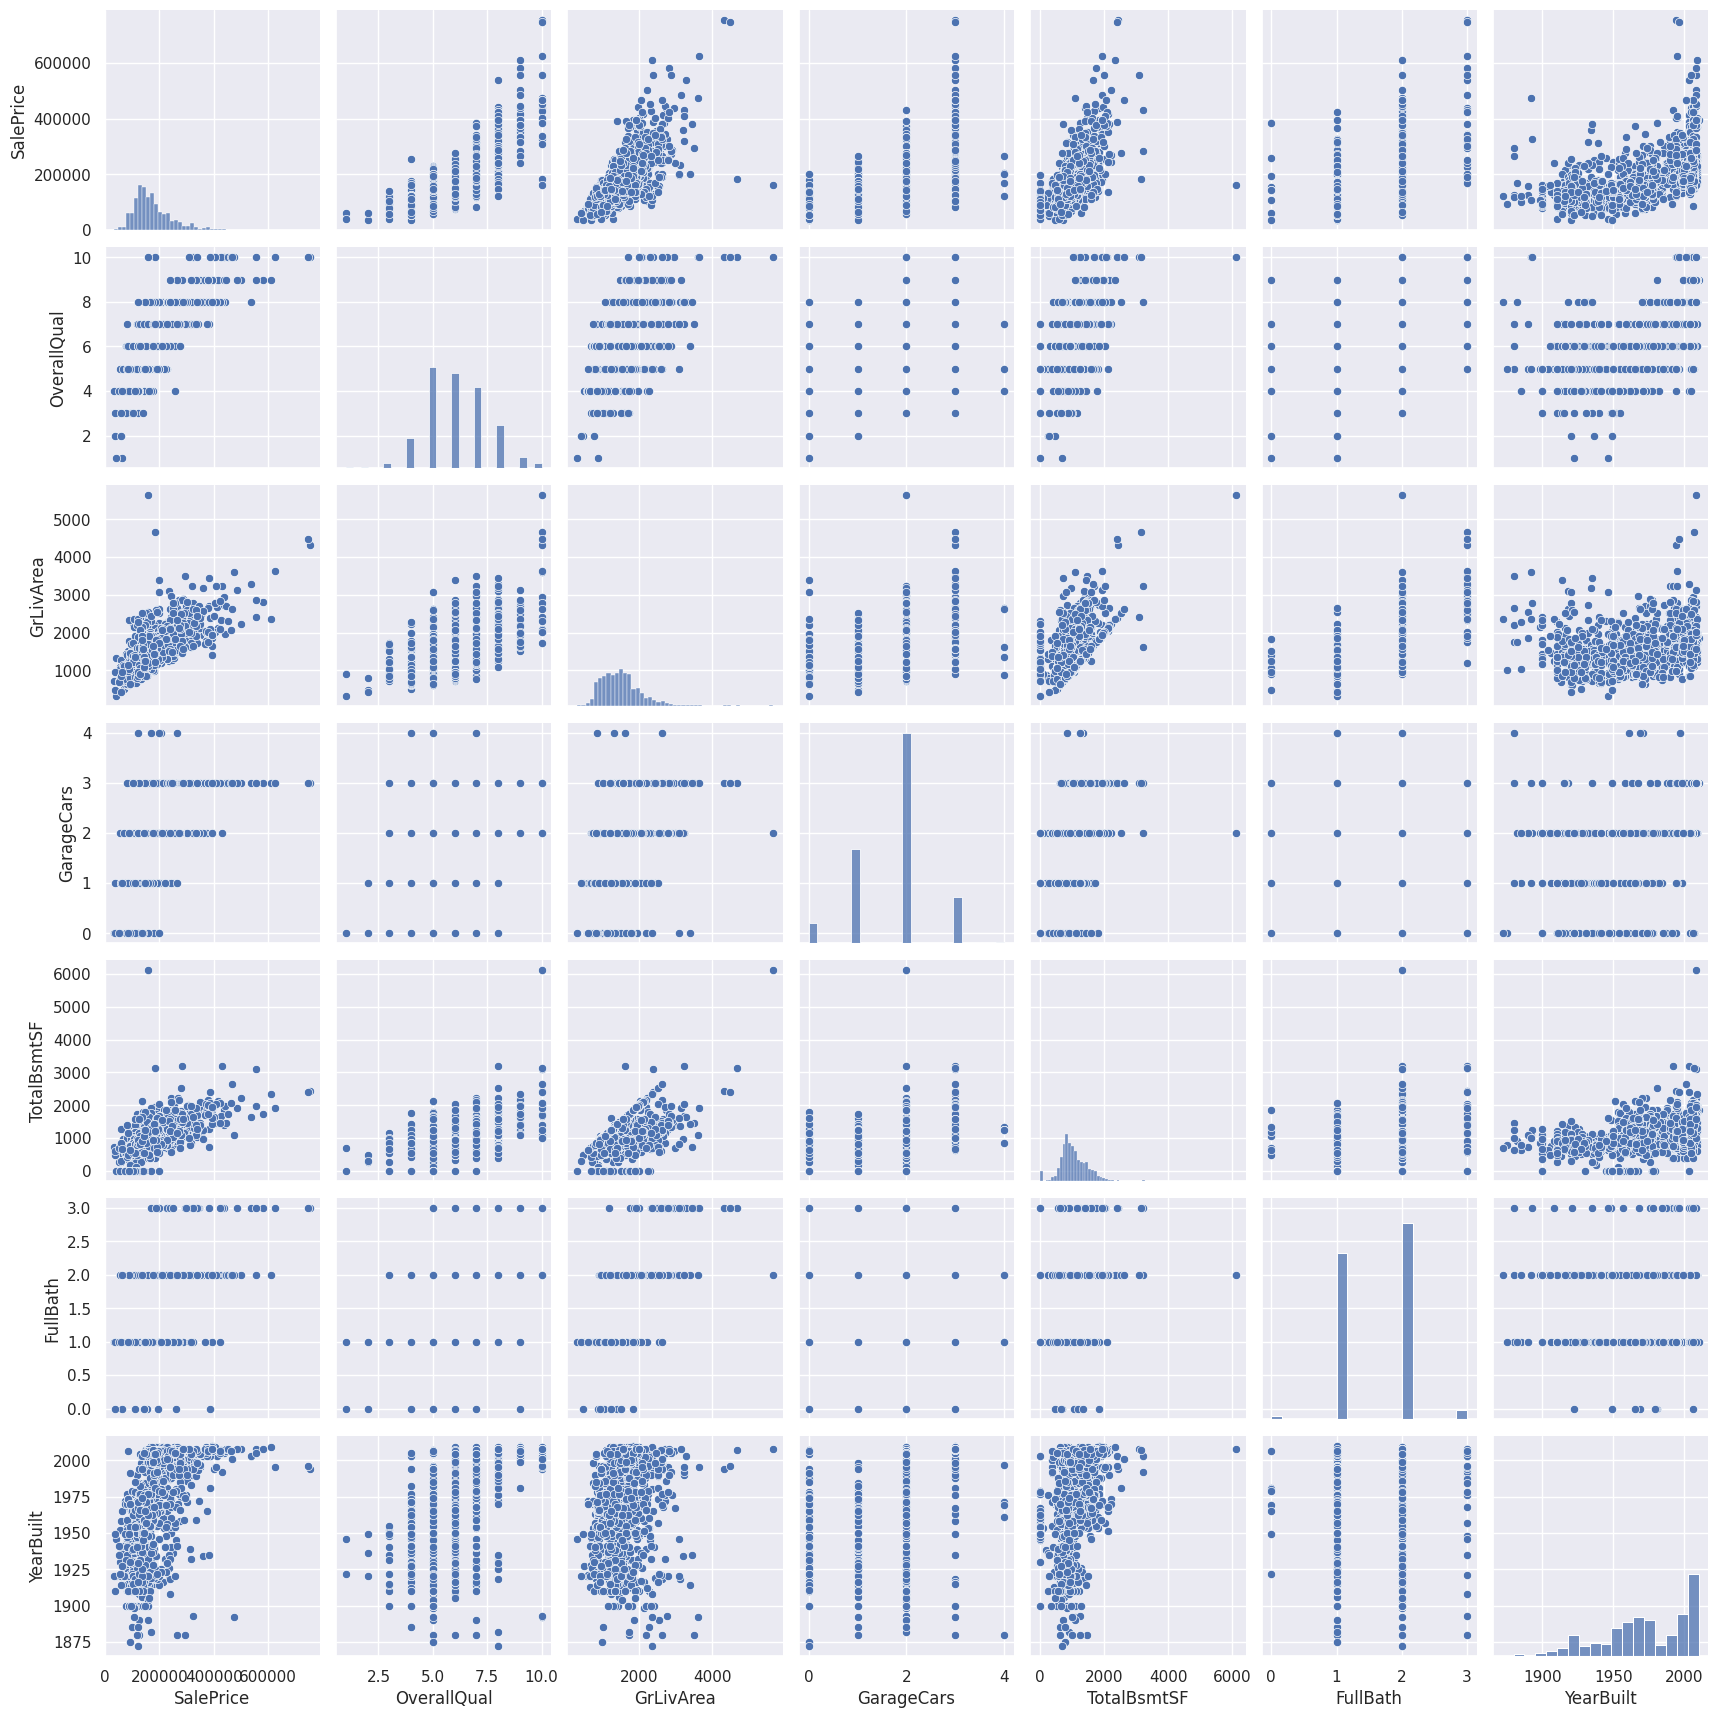

In [49]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_data[cols], size = 2.5)
plt.show();

## Prepare Data for Training

In [50]:
# Revert to clean training data
train_data = train_set.copy()
train_index = train_data.shape[0]
test_index = test_data.shape[0]
target = train_data.SalePrice.values
all_data = pd.concat((train_data, test_data)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.shape

(2919, 80)

In [51]:
# drop the id column for all_data
all_data.drop(['Id'], axis=1, inplace=True)

### Missing Values

In [52]:
# fill categorical features with None for those with missing values
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')
all_data['Alley'] = all_data['Alley'].fillna('None')
all_data['Fence'] = all_data['Fence'].fillna('None')
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

# fill missing data with median neighborhood value
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# fill missing data with the mode
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

# fill missing data (other)
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('FireplaceQu')
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data["Functional"] = all_data["Functional"].fillna("Typ")

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

### Numeric Transformations

In [53]:
# convert columns to strings
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

### Label Encoding

In [54]:
columns = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')

for col in columns:
    encoder = LabelEncoder()
    encoder.fit(list(all_data[col].values))
    all_data[col] = encoder.transform(list(all_data[col].values))

all_data.shape

(2919, 79)

In [55]:
# convert categorical data into binary using dummy variables
all_data = pd.get_dummies(all_data)
all_data.shape

(2919, 222)

In [56]:
train_data = all_data[:train_index]
test_data = all_data[train_index:]

## Train The Models

### Train - Validation Split

In [57]:
X_train, X_val, y_train, y_val = train_test_split(
    train_data, target, test_size=0.20, random_state=42)

In [58]:
X_train

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
254,5,70.000,8400,1,1,3,0,5,5,1957,...,False,False,False,True,False,False,False,False,True,False
1066,10,59.000,7837,1,1,0,0,6,6,1993,...,False,False,False,True,False,False,False,False,True,False
638,6,67.000,8777,1,1,3,0,5,6,1910,...,False,False,False,True,False,False,False,False,True,False
799,9,60.000,7200,1,1,3,0,5,6,1937,...,False,False,False,True,False,False,False,False,True,False
380,9,50.000,5000,1,2,3,0,5,5,1924,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,5,78.000,9317,1,1,0,0,6,4,2006,...,False,False,False,True,False,False,False,False,True,False
1130,9,65.000,7804,1,1,3,0,4,2,1928,...,False,False,False,True,False,False,False,False,True,False
1294,5,60.000,8172,1,1,3,0,5,6,1955,...,False,False,False,True,False,False,False,False,True,False
860,9,55.000,7642,1,1,3,0,7,7,1918,...,False,False,False,True,False,False,False,False,True,False


In [59]:
X_val

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
892,5,70.000,8414,1,1,3,0,6,7,1963,...,False,False,False,True,False,False,False,False,True,False
1105,10,98.000,12256,1,1,0,0,8,4,1994,...,False,False,False,True,False,False,False,False,True,False
413,6,56.000,8960,1,0,3,0,5,5,1927,...,False,False,False,True,False,False,False,False,True,False
522,9,50.000,5000,1,1,3,0,6,6,1947,...,False,False,False,True,False,False,False,False,True,False
1036,5,89.000,12898,1,1,0,0,9,4,2007,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,6,50.000,5925,1,1,3,0,4,6,1937,...,False,False,False,True,False,False,True,False,False,False
1361,5,124.000,16158,1,1,0,1,7,4,2005,...,False,False,False,True,False,False,False,False,True,False
802,10,63.000,8199,1,1,3,0,7,4,2005,...,False,False,False,True,False,False,False,False,True,False
651,11,60.000,9084,1,1,3,0,4,4,1940,...,False,False,False,True,False,False,False,False,True,False


In [60]:
train_data.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=222)

### Model

In [61]:
model = lgb.LGBMRegressor(objective='regression',
                         num_leaves=5,
                         learning_rate=0.05,
                         n_estimators=720,
                         max_bin = 55,
                         bagging_fraction = 0.8,
                         bagging_freq = 5,
                         feature_fraction = 0.2319,
                         feature_fraction_seed=9,
                         bagging_seed=9,
                         min_data_in_leaf =6,
                         min_sum_hessian_in_leaf = 11,
                         verbose=-1)

### Validation Function

In [62]:
n_folds = 5

y_train_scaled = np.log1p(y_train)
y_val_scaled = np.log1p(y_val)

def rmse_cv(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5))
    return rmse

### Train Scores

In [63]:
X = X_train
y = y_train_scaled

score = rmse_cv(model, X, y)
print("Model score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

Model score: 0.1223 (0.0136)



## Validate Model

In [64]:
def rmse_cv_val(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5))
    return rmse

In [65]:
X = X_val
y = y_val_scaled


score = rmse_cv_val(model, X, y)
print("Validation score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Validation score: 0.1526 (0.0265)



## Create the Submission

### Final Fit

In [66]:
X = X_train
y = y_train_scaled
model.fit(X, y)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              feature_fraction=0.2319, feature_fraction_seed=9,
              learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
              min_sum_hessian_in_leaf=11, n_estimators=720, num_leaves=5,
              objective='regression', verbose=-1)

### Create Output

In [67]:
X = test_data
predictions = np.exp(model.predict(X))
result=pd.DataFrame({'Id':test_ids, 'SalePrice':predictions})

In [68]:
# save result to a CSV file
result.to_csv('submission.csv', index=False)

In [69]:
from google.colab import files
# Download the CSV file
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>